# Network training  

## Data Loading Functions


In [1]:
import os
import glob
from typing import List, Tuple
import numpy as np

def get_carla_data_files(data_dir: str, min_timestamp: str = "20241209_173218_948893") -> List[Tuple[str, float]]:
    """
    Get all valid training files from the Carla dataset directory and their steering angles.
    
    Args:
        data_dir: Path to the carla_dataset directory
        min_timestamp: Minimum timestamp to include (as string)
    
    Returns:
        List of tuples containing (file_path, steering_angle)
    """
    # Get all jpg files in directory
    pattern = os.path.join(data_dir, "*.jpg")
    all_files = glob.glob(pattern)
    
    valid_files = []
    for file_path in all_files:
        # Get filename without extension
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        
        # Check if filename matches expected pattern
        if len(parts) >= 5 and 'steering' in filename:
            # Extract timestamp and steering
            timestamp = '_'.join(parts[0:3])  # Combine timestamp parts
            try:
                steering = float(parts[-1].replace('.jpg', ''))
                
                # Only include files with timestamp >= min_timestamp
                if timestamp >= min_timestamp:
                    valid_files.append((file_path, steering))
            except ValueError:
                continue  # Skip if steering value can't be converted to float
    
    # Sort by timestamp
    valid_files.sort(key=lambda x: os.path.basename(x[0]).split('_')[0:3])
    
    return valid_files

def train_val_split(file_pairs: List[Tuple[str, float]], val_ratio: float = 0.2) -> Tuple[List[Tuple[str, float]], List[Tuple[str, float]]]:
    """
    Split the dataset into training and validation sets.
    
    Args:
        file_pairs: List of (file_path, steering_angle) tuples
        val_ratio: Ratio of validation set size to total dataset size
    
    Returns:
        Tuple of (train_pairs, val_pairs)
    """
    # Create random indices
    num_samples = len(file_pairs)
    indices = np.random.permutation(num_samples)
    split_idx = int(np.floor(val_ratio * num_samples))
    
    # Split into training and validation sets
    val_indices = indices[:split_idx]
    train_indices = indices[split_idx:]
    
    train_pairs = [file_pairs[i] for i in train_indices]
    val_pairs = [file_pairs[i] for i in val_indices]
    
    return train_pairs, val_pairs

# Example usage:
if __name__ == "__main__":
    # Test the functions
    data_dir = "carla_dataset"
    files = get_carla_data_files(data_dir)
    print(f"Found {len(files)} valid files")
    
    train_files, val_files = train_val_split(files)
    print(f"Split into {len(train_files)} training and {len(val_files)} validation samples")

Found 15306 valid files
Split into 12245 training and 3061 validation samples


## Dataset class

In [2]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from typing import List, Tuple

class CarlaDataset(Dataset):
    """
    PyTorch Dataset for Carla steering angle prediction.
    Handles loading and preprocessing of images, and conversion to tensors.
    """
    def __init__(self, 
                 file_pairs: List[Tuple[str, float]], 
                 crop_top: int = 260,
                 crop_bottom: int = 440,
                 transform=None):
        """
        Initialize the dataset.
        
        Args:
            file_pairs: List of tuples containing (image_path, steering_angle)
            crop_top: Y coordinate where crop begins
            crop_bottom: Y coordinate where crop ends
            transform: Optional additional transformations
        """
        self.file_pairs = file_pairs
        self.crop_top = crop_top
        self.crop_bottom = crop_bottom
        self.transform = transform

    def __len__(self) -> int:
        """Return the total number of samples in the dataset."""
        return len(self.file_pairs)
    
    def prepare_image_for_neural_network(self, image_path: str) -> np.ndarray:
        """
        Load image, crop, resize, and convert to YUV for neural network processing.
        
        Args:
            image_path: Path to the input image
            
        Returns:
            numpy array in YUV format, size 66x200x3
        """
        # Read and convert image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Crop
        cropped = img_rgb[self.crop_top:self.crop_bottom, :]
        
        # Resize to neural network input size (66x200)
        resized = cv2.resize(cropped, (200, 66))
        
        # Convert to YUV
        yuv = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
        
        return yuv

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get a sample from the dataset.
        
        Args:
            idx: Index of the sample to get
            
        Returns:
            tuple: (image, steering_angle) where image is a preprocessed torch tensor
                  and steering_angle is a torch tensor
        """
        image_path, steering_angle = self.file_pairs[idx]
        
        # Load and preprocess image
        image = self.prepare_image_for_neural_network(image_path)
        
        # Convert to torch tensor and adjust dimensions for PyTorch (CHW instead of HWC)
        image_tensor = torch.from_numpy(image).float()
        image_tensor = image_tensor.permute(2, 0, 1)  # Change from HWC to CHW format
        
        # Convert steering angle to tensor
        steering_tensor = torch.tensor(steering_angle, dtype=torch.float32)
        
        # Apply any additional transforms if specified
        if self.transform:
            image_tensor = self.transform(image_tensor)
            
        return image_tensor, steering_tensor


## Example Usage

In [3]:
# Example usage in Jupyter notebook:
from torch.utils.data import DataLoader

# Get file pairs
data_dir = "carla_dataset"  # adjust path as needed
file_pairs = get_carla_data_files(data_dir)
print(f"Total number of samples: {len(file_pairs)}")

# Split into train and validation sets
train_pairs, val_pairs = train_val_split(file_pairs)
print(f"Training samples: {len(train_pairs)}, Validation samples: {len(val_pairs)}")

# Create datasets
train_dataset = CarlaDataset(train_pairs)
val_dataset = CarlaDataset(val_pairs)

# Create dataloaders with appropriate num_workers for Jupyter
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)  # num_workers=0 for Jupyter
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

# Test loading a single batch
images, steering = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")  # Should be [batch_size, 3, 66, 200]
print(f"Batch steering shape: {steering.shape}")  # Should be [batch_size]

Total number of samples: 15306
Training samples: 12245, Validation samples: 3061
Batch image shape: torch.Size([64, 3, 66, 200])
Batch steering shape: torch.Size([64])


## Model training helper functions

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class NVIDIANet(nn.Module):
    def __init__(self, num_outputs=1, dropout_rate=0.1):
        super(NVIDIANet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, num_outputs)
        
    def forward(self, x):
        # Input normalization
        x = x / 255.0
        
        # Convolutional layers with ELU activation and dropout
        x = F.elu(self.conv1(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv2(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv3(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv4(x))
        x = self.dropout(x)
        
        x = F.elu(self.conv5(x))
        x = self.dropout(x)
        
        # Flatten and dense layers
        x = self.flatten(x)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        
        return x

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=6, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state_dict = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_state_dict = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_state_dict = model.state_dict().copy()
            self.counter = 0
            return True  # Indicates we have a new best model
        return False  # Indicates this is not a new best model

def train_model(model, train_loader, val_loader, model_save_path, num_epochs=100, device="cuda", learning_rate=1e-5):
    """Training loop with validation and early stopping"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=6)
    
    # History for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for images, steering in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            steering = steering.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), steering)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for images, steering in val_loader:
                images = images.to(device)
                steering = steering.to(device)
                
                outputs = model(images)
                val_loss = criterion(outputs.squeeze(), steering)
                val_losses.append(val_loss.item())
        
        # Calculate average losses
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        
        # Save to history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping check
        is_best = early_stopping(avg_val_loss, model)
        
        # Save if it's the best model
        if is_best:
            print(f"New best model! Saving to {model_save_path}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, model_save_path)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            print(f"Loading best model from {model_save_path}")
            model.load_state_dict(early_stopping.best_state_dict)
            break
    
    return model, history

def load_model(model, model_path, device='cuda'):
    """Load a saved model"""
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def plot_training_history(history):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_steering_model(train_dataset, val_dataset, model_save_path, batch_size=64):
    """Full training pipeline"""
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model
    model = NVIDIANet(num_outputs=1)
    
    # Train model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        model_save_path=model_save_path,
        num_epochs=100,
        device=device,
        learning_rate=1e-5
    )
    
    # Plot training history
    plot_training_history(history)
    
    return trained_model, history

## Train    

Epoch 1/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.0135, Val Loss: 0.0003


Epoch 2/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.0004, Val Loss: 0.0003
New best model! Saving to best_steering_model_v1.pth


Epoch 3/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.0004, Val Loss: 0.0003
New best model! Saving to best_steering_model_v1.pth


Epoch 4/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 5/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 6/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0004, Val Loss: 0.0003
New best model! Saving to best_steering_model_v1.pth


Epoch 7/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0004, Val Loss: 0.0003
New best model! Saving to best_steering_model_v1.pth


Epoch 8/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 9/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 10/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 11/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 12/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0004, Val Loss: 0.0003


Epoch 13/100:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.0004, Val Loss: 0.0003
Early stopping triggered
Loading best model from best_steering_model_v1.pth


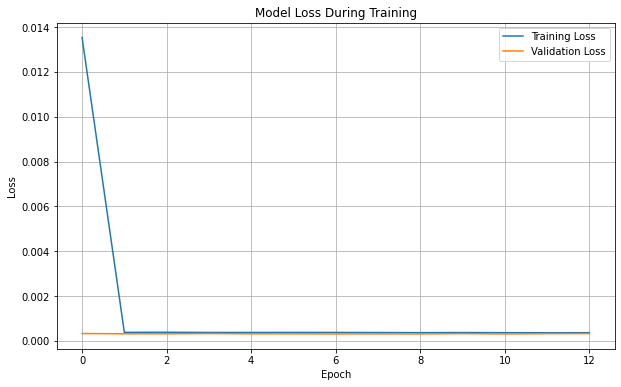

: 

In [7]:
# Training
model_save_path = 'best_steering_model_v1.pth'
model, history = train_steering_model(
    train_dataset, 
    val_dataset, 
    model_save_path=model_save_path
)

# Later, when you need to load the model for self-driving:
model = NVIDIANet(num_outputs=1)
model = load_model(model, model_save_path)